In [11]:
#importing required libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [12]:
#Collecting list of US States
df_get_state_names = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-07-2020.csv")
df_state_names = []
for state in df_get_state_names['Province_State']:
    df_state_names.append(state.replace(" ","").lower())


In [13]:
#Accepting Input from User what state's information he is looking for
#Validation is provided, if not valid name, gives error
#In case it gives error, run the cell one more time to add Valid state name
enteredStateName = input("Which state's information are you looking for?")
isValidName = False
for state in df_state_names:
    if enteredStateName.replace(" ","").lower() == state:
        isValidName = True
if isValidName == False :
    print("Please enter a valid state name")

Which state's information are you looking for?Vermont


In [14]:
#Data processing to match entered state with state list
df_confirmed_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
df_confirmed_cases['Province_State'] = df_confirmed_cases['Province_State'].str.replace(" ","")
df_confirmed_cases['Province_State'] = df_confirmed_cases['Province_State'].str.lower()
print(df_confirmed_cases['Province_State'])

0                americansamoa
1                         guam
2       northernmarianaislands
3                   puertorico
4                virginislands
                 ...          
3256                      utah
3257                      utah
3258                      utah
3259                      utah
3260                      utah
Name: Province_State, Length: 3261, dtype: object


In [15]:
#Plot New and Cummulative Cases graph for entered State
selected_state_data = df_confirmed_cases.loc[df_confirmed_cases['Province_State'] == enteredStateName.replace(" ","").lower()]
#a function to plaot graph for new cases and cummulative cases number on daily basis
def plot_confirmed_cases_graph():
    #gathering data for x-axis
    x_data = np.array(list(selected_state_data.iloc[:, 11:].columns))
    #gathering data for y-axis both for cummulative cases and new cases lines
    y_data_cummulative = []
    y_data_newDaily = [0]
    for index,indate in enumerate(x_data,start=0):
        y_data_cummulative.append(np.sum(selected_state_data[indate]))
        if index > 0 :
            y_data_newDaily.append(np.sum(selected_state_data[indate]) - y_data_cummulative[index-1])
    #defining label text        
    labelText_cummulative = "Cummulative Cases: " + enteredStateName
    labelText_new_daily = "New Cases: " + enteredStateName
    #creating figure instance
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_data, y=y_data_cummulative, text=(labelText_cummulative)))
    fig.add_trace(go.Scatter(x=x_data, y=y_data_newDaily, text=(labelText_new_daily)))
    fig.show()
plot_confirmed_cases_graph()    


(70, 4)


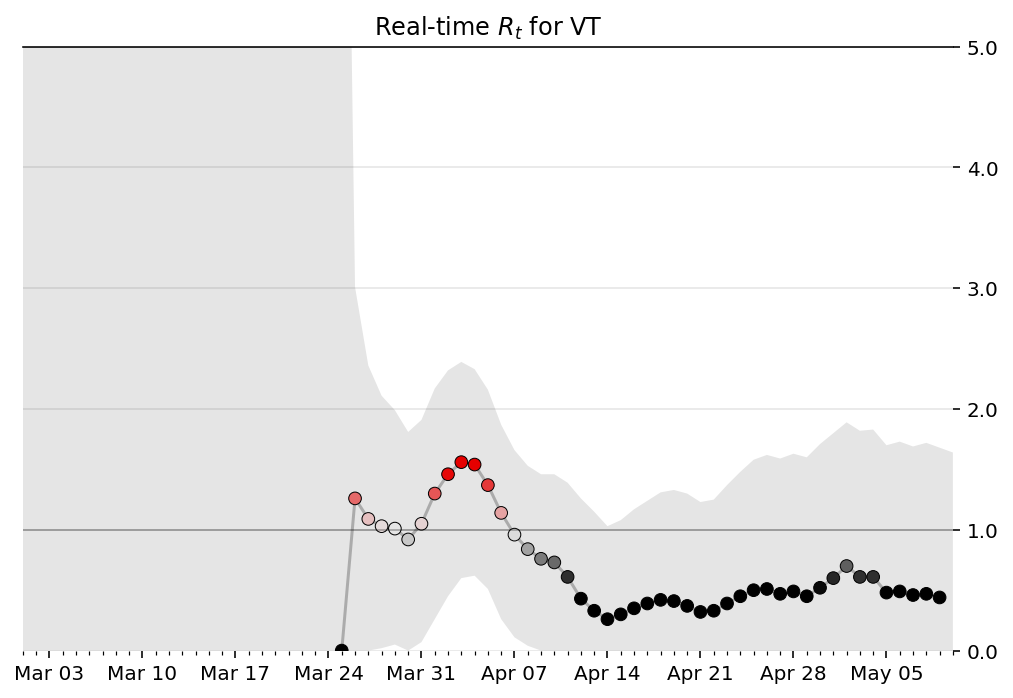

In [16]:
#RT value graph for entered state
#code taken from https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
#Choosing a Likelihood Function
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

#Calucate Maximum Likelihood
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

#Performing the Bayesian Update
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)



most_likely_values = posteriors.idxmax(axis=0)

def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)

#Apply above functions to calculate Rt value of US States based on Covid 19 data

url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

statesList = pd.read_csv("./Data/US_States_abbr.csv")
state_name= 'NY'
for index,state in enumerate(statesList['State'],start=0):
    if state.replace(" ","").lower() == enteredStateName.replace(" ","").lower():
        state_name = statesList['Abbr'][index]

#Calculate Daily cases and apply Gaussian Distribution

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)


#Plot the Rt graph for entered State
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


In [18]:
#Calculate Positive Test Rate
#chossing date, state, positive,negative,pending tests number columns
df_testing_data = pd.read_csv(url,
                     usecols=['date', 'state', 'positive','negative','pending'],
                     parse_dates=['date'],
                     index_col=['state'],
                     squeeze=True).sort_index() 
#replacing NaN values with 0
df_testing_data.fillna(0,inplace=True)

#shortlisting data for only enteredState
df_testing_data = df_testing_data.xs(state_name)

#arranging dates in ascending order
df_testing_data = df_testing_data.sort_values('date',ascending=True)
x_data_posRate = df_testing_data['date']

#labeltext for graph
posRate_labelText = "Postive Test rate: " + enteredStateName

#calulating percentage for positive tests to total number of tests done
y_data_posRate = (df_testing_data['positive']/( df_testing_data['positive']+df_testing_data['negative']+df_testing_data['pending']))*100
fig_posRate = go.Figure()
fig_posRate.add_trace(go.Scatter(x=x_data_posRate, y=y_data_posRate, text=(posRate_labelText)))
#fig_posRate = px.line(df_testing_data, x=x_data_posRate, y=y_data_posRate, title='Positive Rate')
fig_posRate.show()

In [19]:
#ICU Beds Utilization
#chossing date, state, inICUCurrently columns
df_total_icuCount = pd.read_csv(url,
                     usecols=['date', 'state', 'inIcuCurrently'],
                     parse_dates=['date'],
                     index_col=['state'],
                     squeeze=True).sort_index() 
df_total_icuCount = df_total_icuCount.sort_values('date',ascending=True)
df_total_icuCount.fillna(0,inplace=True)
df_total_icuCount = df_total_icuCount.xs(state_name)

#getting data for total numbers of beds available for any state
df_total_icuBeds = pd.read_csv('https://raw.githubusercontent.com/covid-projections/covid-data-public/master/data/covid-care-map/healthcare_capacity_data_state.csv',
                          usecols=['State', 'Staffed ICU Beds'],index_col=['State'])
#arranging states in ascending manner
df_total_icuBeds= df_total_icuBeds.sort_values('State',ascending=True)

#shortlisting data for only enteredState
df_total_icuBeds = df_total_icuBeds.xs(state_name)
print(df_total_icuBeds['Staffed ICU Beds'])

#x-xis data
x_data_icuutilDate = df_total_icuCount['date']

#y-axis data (percentage of currentlyICUadmittedpatient to total number of beds available)
y_data_icuutilDate = df_total_icuCount['inIcuCurrently']*100/df_total_icuBeds['Staffed ICU Beds']
icuUtil_labelText = "ICU Beds Utilization: " + enteredStateName
fig_icuUtil = go.Figure()
fig_icuUtil.add_trace(go.Scatter(x=x_data_icuutilDate, y=y_data_icuutilDate, text=(icuUtil_labelText)))
#fig_posRate = px.line(df_testing_data, x=x_data_posRate, y=y_data_posRate, title='Positive Rate')
fig_icuUtil.show()

94.0


In [20]:
#Score Calculation

#calculate 7days aggregate value for each criteria
def calculateAggregate(df):
    currentVal = 0
    for value in df:
        currentVal = currentVal + value
    currentVal = currentVal/10
    return currentVal


#generate score card e.g [40. 36. 32. 28. 24. 20. 16. 12.  8.  4.  0.]
def generateScroreCard(max):
    i = 1
    scoreArray = [0]
    while i<10:
        scoreArray.append(scoreArray[i-1] + (max/10))
        i=i+1
    scoreArray.append(max)
    scoreArray = np.array(scoreArray)
    scoreArray = scoreArray[::-1]
    return scoreArray

#calculate score for each criteria
def getScore(currentVal,ScoreCard):
    for index,val in enumerate(ScoreCard,start=0):
        if(val <= currentVal):
            return index
            
        

currentRtValue = calculateAggregate(result['ML'].values[-10:])
print(currentRtValue)

currentPositiveRate = calculateAggregate(y_data_posRate[-10:])
print(currentPositiveRate)

currentICUBedUtilization = calculateAggregate(y_data_icuutilDate[-10:])
print(currentICUBedUtilization)

#genearting score card for each criteria
productionRateScoreCard = generateScroreCard(3)
positiveRateScoreCard = generateScroreCard(40)
icuBedUtilScoreCard = generateScroreCard(70)

#calculating score based on aggregate value for each criteria
productionRateScore = getScore(currentRtValue,productionRateScoreCard)
postiveRateScore = getScore(currentPositiveRate,positiveRateScoreCard)
icuutilScore = getScore(currentICUBedUtilization,icuBedUtilScoreCard)

#Calculating final Score
finalScore = (productionRateScore + postiveRateScore + icuutilScore)/3
print(finalScore)
if(finalScore <= 8):
    print("Situation should be reconsidered before re-opening economy")
else:
    print("Can think of re-opening economy following with social distancing guideline")

0.538
5.155583394731407
0.6382978723404256
[3.  2.7 2.4 2.1 1.8 1.5 1.2 0.9 0.6 0.3 0. ]
[40. 36. 32. 28. 24. 20. 16. 12.  8.  4.  0.]
[70. 63. 56. 49. 42. 35. 28. 21. 14.  7.  0.]
9
9
10
9.333333333333334
Can think of re-opening economy following with social distancing guideline
